# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

##### Importing necessary libraries

In [1]:
# Standard library imports
import sys

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from itertools import product

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
from utils import *  
from plotting import *

sys.path.append('./solver')
from random_process import *
from model import Model


2024-07-11 18:23:17.698333: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ray module not found. Multiprocessing features are not available


#### Decide sample to use for experimental data

In [2]:
sample = 111 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

#### Set Bayesian Identification Parameters

In [3]:
noise = 0.001

#### Load Surrogate Models

In [4]:
# Extract test data for visualization or further processing
X_values = np.loadtxt('./data/X_test.csv', delimiter = ',')
y_values = np.loadtxt('./data/y_test.csv',delimiter = ',')

In [5]:
# Set the resolution of the model and the random field parameters.
resolution = (50, 50)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl_fine = 64

model_fine = Model(resolution, field_mean, field_stdev, mkl_fine, lamb_cov)

# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))



def model_hf(x):
    model_fine.solve(x)
    return np.array(model_fine.get_data(datapoints)).reshape(25)


### Define a custom Uniform random variable class

In [6]:
# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# Set the likelihood
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*10)

#### Perform least square optimization for each starting point

In [7]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-2.5*np.ones(64), 2.5*np.ones(64))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_hf , 
        start_point=np.zeros(64), #+  np.random.normal(scale=0.01,size=x_true.shape[0]), 
        bounds=bounds
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 6.07650264e-01 -8.78402244e-01  4.06663556e-04 -1.86166846e-01
 -2.97918469e-03 -4.48376340e-03 -1.22163996e-01 -2.37819638e+00
 -1.26224397e+00  1.50821057e+00  1.02839589e+00 -1.15895316e+00
  5.46821352e-01 -6.44307210e-01  1.02496769e+00  3.77303262e-01
 -1.68004872e+00 -8.36349426e-01 -5.79371048e-01  3.63959512e-01
  1.47578306e+00 -6.88356705e-01  6.47310114e-01 -1.61210316e+00
 -1.26842480e+00 -9.79458675e-01 -2.60914875e-01  6.39481321e-01
 -1.00221754e+00  1.28199025e+00  2.82918339e-01  8.02258582e-01
 -1.45885147e+00 -1.33381279e-01  1.30187464e+00  1.30172503e+00
 -6.34388912e-02  9.64635983e-02  4.28349512e-01 -1.69327233e+00
 -4.65579891e-01  5.07873211e-01 -4.08237773e-01 -5.87403509e-01
  1.03857666e+00  9.68174169e-01 -1.52847938e+00 -5.09519078e-01
  3.80445164e-01  9.76485640e-01  1.08563060e+00 -2.30176926e-02
  1.07633620e+00 -9.25089483e-01 -5.48907702e-01  7.27433450e-01
  2.61003812e-01 -2.35570489e-01 -1.08913931e+00  7.35836205e-01
 -5.8881470

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [8]:
scaling = 0.02
n_iter =  55000
burnin = 5000
thin = 50

In [9]:
#cov = np.diag(np.linspace(1,3,64))
cov = np.eye(64)

In [10]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=cov, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

In [11]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=x_true)
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )




Sampling chain 1/1


Running chain, α = 0.09: 100%|██████████| 55000/55000 [19:42<00:00, 46.50it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1001), minimum_shape: (chains=2, draws=4)


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 11.56
    x1       float64 8B 1.336
    x2       float64 8B 1.335
    x3       float64 8B 1.566
    x4       float64 8B 1.416
    x5       float64 8B 3.153
    ...       ...
    x58      float64 8B 1.318
    x59      float64 8B 2.273
    x60      float64 8B 3.437
    x61      float64 8B 12.26
    x62      float64 8B 1.443
    x63      float64 8B 1.514 




Rhat:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B nan
    x1       float64 8B nan
    x2       float64 8B nan
    x3       float64 8B nan
    x4       float64 8B nan
    x5       float64 8B nan
    ...       ...
    x58      float64 8B nan
    x59      float64 8B nan
    x60      float64 8B nan
    x61      float64 8B nan
    x62      float64 8B nan
    x63      float64 8B nan


Let's look at the trace plot of one chain

# Diagnostics 

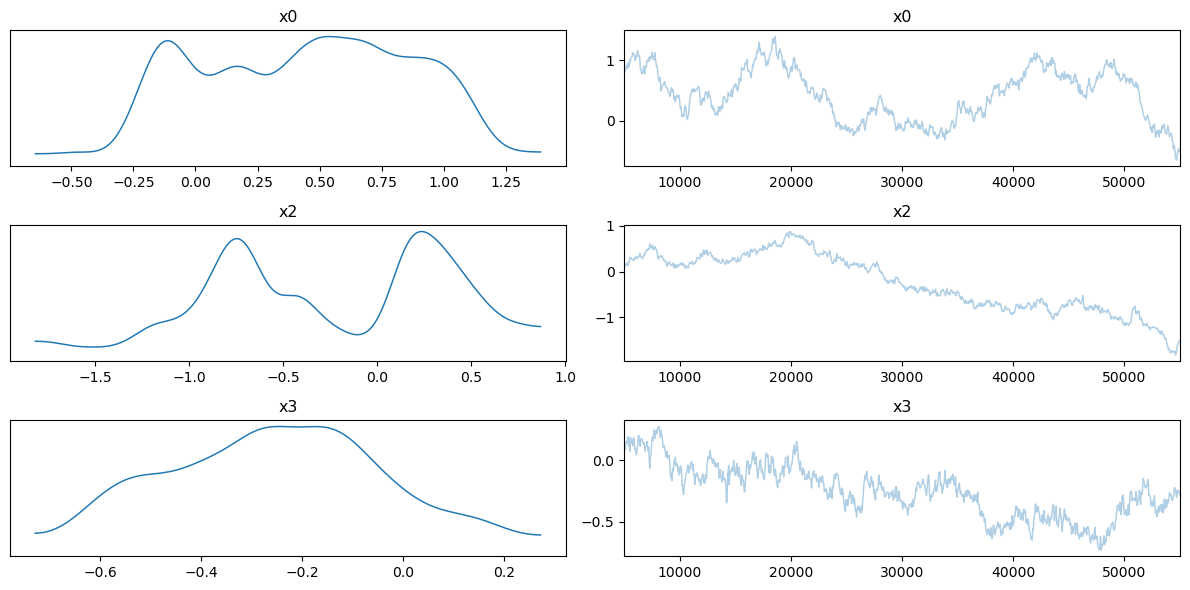

In [12]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

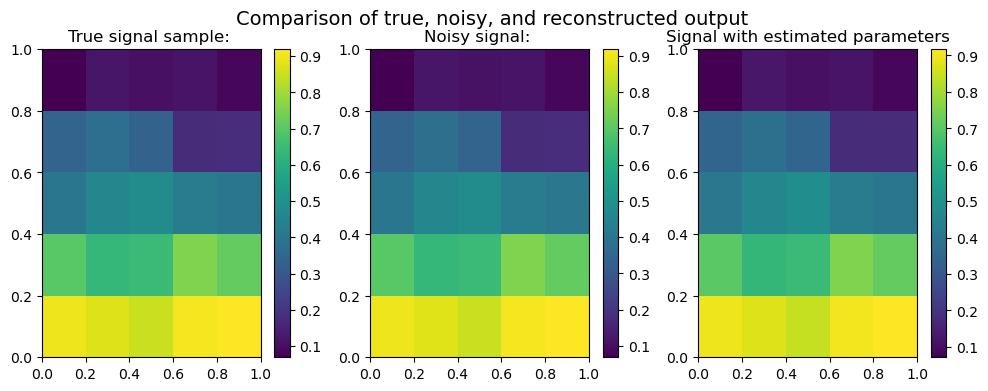

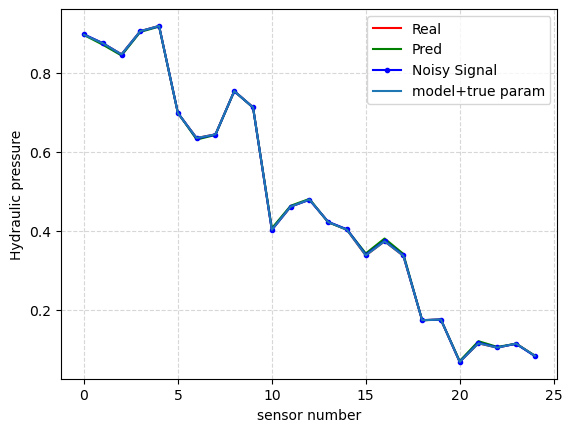

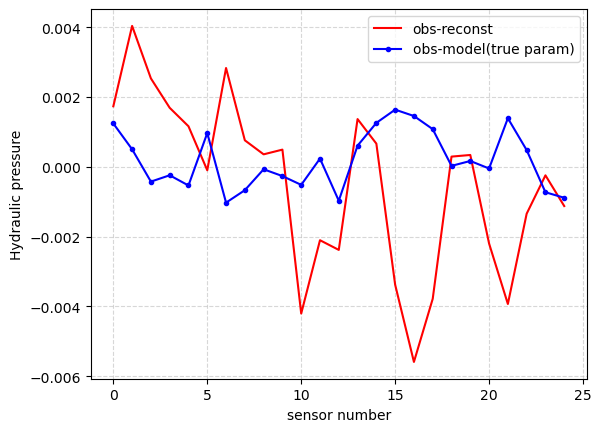

In [13]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, 64, x_true)

Finally, let's look at the parameters distribution

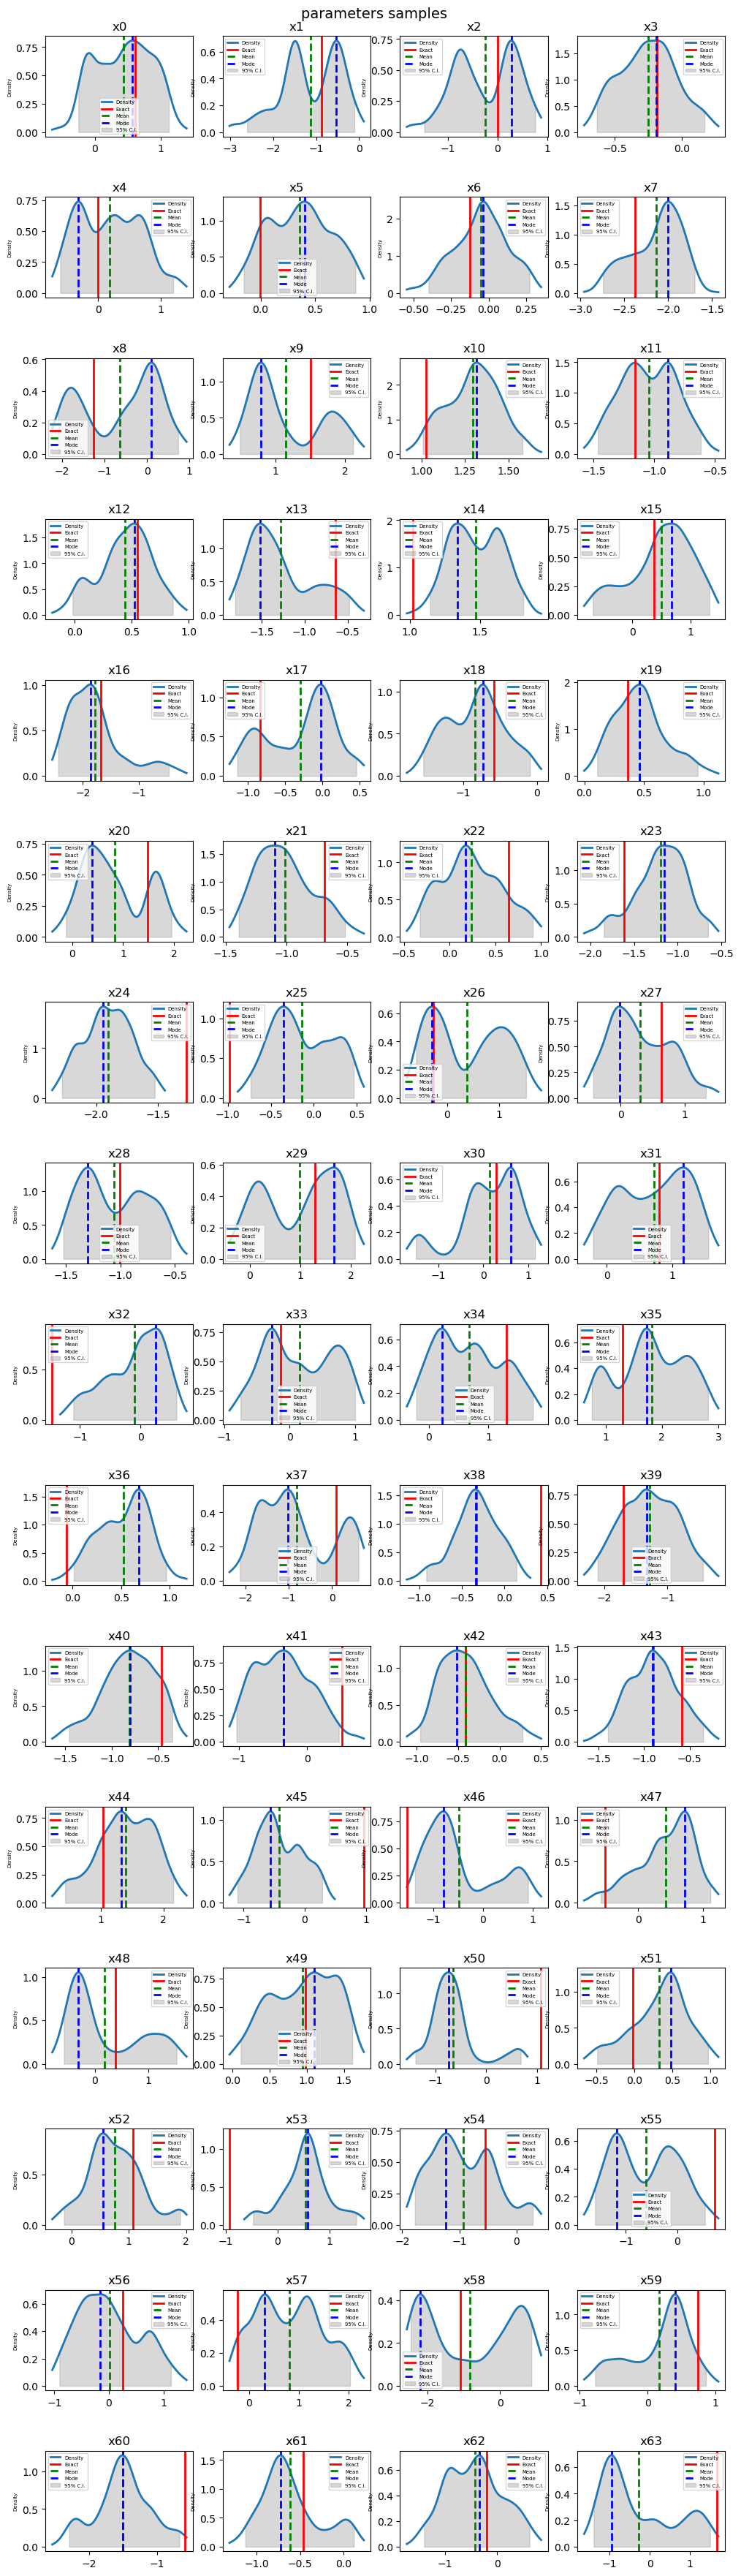

In [14]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, 64) 

### Reconstructed field 

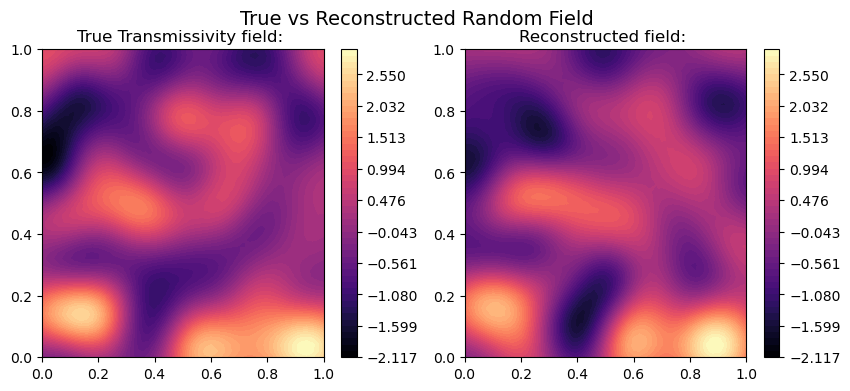

In [15]:
plot_fields(x_true=x_true, x_estimated=data.mean(axis=0),n_eig=64, lognormal=False)